$ \theta = \{\psi, \sigma \} $

$\psi$: Parametros para definição do modelo que será utilizado em cada estado<br>
$\sigma$: Parametros para cada Modelo $\{\sigma_1, \sigma_2, ...\}$ <br>

$ \beta: S \mapsto [0,1]^k \;\; onde \;\; k = |\sigma|$ <br>
$ \beta(s; \psi)_i = p_{\psi}(\sigma_i | s) \; \forall \; i \in (1, 2, ..., k)$ <br>
A função $ \beta $ define a probabilidade de cada parametro em $ \sigma $ ser o modelo utilizado pra gerar a transição em um estado <br>

$\mu: S \times S \times A \times \sigma \mapsto [0,1] $ <br>
$\mu(s', s, a, \sigma_x)= p_{\sigma_x}(s'|s,a)$ <br>
A função $ \mu $ define a probabilidade de transição para um estado, dado um par de estado e ação, seguindo o modelo $\sigma_x$ <br>

In [164]:
import numpy as np
import random

force = .5
actions = np.array([(force,0), (-force,0), (0,force), (0,-force)])
theta = [5, (.005,.3)]

def mu(s, a, p=2):
    acts = actions[a]
    return s + acts + np.random.normal(0, p, 2)

def beta(x,y):
    psi, _ = theta
    return 1*((x**2 + y**2)**(1/2) < psi)

def generate(s0, n):   
    _, sigma = theta
    s = s0
    for _ in range(n):
        a = np.random.choice(4, 1)[0]
        m = beta(s[:,0], s[:,1])[0]
        sa = np.insert(s, s.size, a)
        yield np.insert(sa, sa.size, m)
        s = mu(s, a, sigma[m])

def trajectory(s_0=(1,1), n=100):
    gen = generate(s_0, n)
    return np.fromiter(gen, dtype=np.dtype((float, 4)))

s_0 = np.array([[0,0]])
n = 1000

O = trajectory(s_0, n)
# O[:] # all
# O[:,0:2] # states
# O[:,2] # actions
# O[:,3] # hidden models


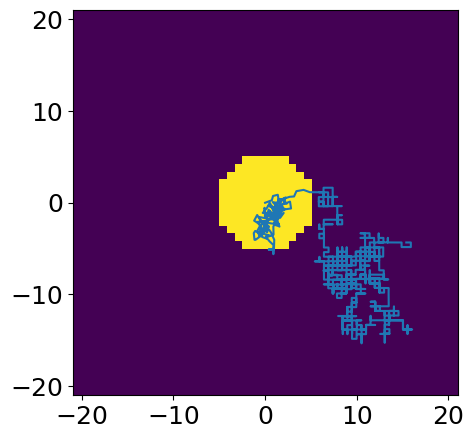

In [165]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
# ax.invert_yaxis()

size = 20
res = 50
x = np.linspace(-size, size, res).reshape(-1,1)
y = np.linspace(-size, size, res).reshape(-1,1)

X,Y = np.meshgrid(x,y)
ax.imshow(beta(X,Y), extent=(int(min(x))-1, int(max(x))+1, int(max(y))+1, int(min(y))-1))
ax.invert_yaxis()

x = np.array(O)[:,0]
y = np.array(O)[:,1]
ax.plot(x, y)

In [166]:
import torch
from torch.autograd import Variable
from torch.distributions import normal
import torch.nn as nn
import torch.nn.functional as f

class BetaModel(nn.Module):
    def __init__(self):
        super(BetaModel, self).__init__()
        n_features = 2
        n_models = 2
        n_hidden = 10

        self.model = nn.Sequential(
            nn.Linear(n_features, n_hidden).double(),
            nn.ReLU(),
            # nn.Linear(n_hidden, n_hidden).double(),
            # nn.ReLU(),
            nn.Linear(n_hidden, n_models).double(),
            nn.ReLU(),
            nn.Softmax(dim=1)
            # nn.Softmax()
        )
        
    def forward(self, x):
        return self.model(x)

In [167]:

def train(model, data, epochs=1000):
    x_train_tensor = torch.from_numpy(data[:,0:2]).type(torch.DoubleTensor)
    # y_train_tensor = torch.from_numpy(data[:,3], 1-data[:,3]).type(torch.DoubleTensor)
    y_train_tensor = torch.from_numpy(np.stack((data[:,3], 1-data[:,3]), axis=-1)).type(torch.DoubleTensor)

    optim = torch.optim.SGD(model.parameters(), lr=1e-2)#, momentum=0.9)
    # loss = nn.MSELoss(reduction='mean')
    loss = nn.CrossEntropyLoss()

    model.train(True)
    for epoch in range(epochs):
        outputs = model(x_train_tensor)
        ll = loss(outputs, y_train_tensor)
        if ll.data == torch.inf or torch.isnan(ll.data):
            break
        ll.backward()
        optim.step() 
        optim.zero_grad()
    model.train(False)

    return ll


In [168]:

beta_model = BetaModel()
train(beta_model, O)

tensor(0.3749, dtype=torch.float64, grad_fn=<DivBackward1>)

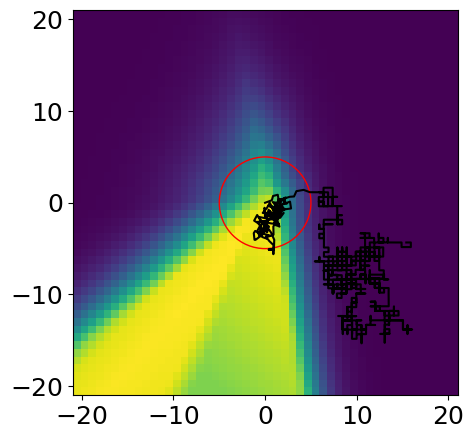

In [169]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

fig, ax = plt.subplots(figsize=(5, 5))
x = np.linspace(-size, size, res).reshape(-1,1)
y = np.linspace(-size, size, res).reshape(-1,1)

X,Y = np.meshgrid(x,y)

with torch.no_grad():
    d = np.stack((X, Y), axis=-1).reshape(-1, 2)
    d = torch.from_numpy(d).type(torch.DoubleTensor)
    corr = beta_model(d)[:,0].reshape(int(X.size**(1/2)), int(X.size**(1/2)))
    # ax.imshow(corr, extent=(-r, r, r, -r), vmin=0, vmax=1)
    ax.imshow(corr, extent=(int(min(x))-1, int(max(x))+1, int(max(y))+1, int(min(y))-1))
ax.invert_yaxis()

x = np.array(O)[:,0]
y = np.array(O)[:,1]
ax.add_patch(Circle((0, 0), theta[0], edgecolor='red', fill=False))
ax.plot(x, y, color='black')


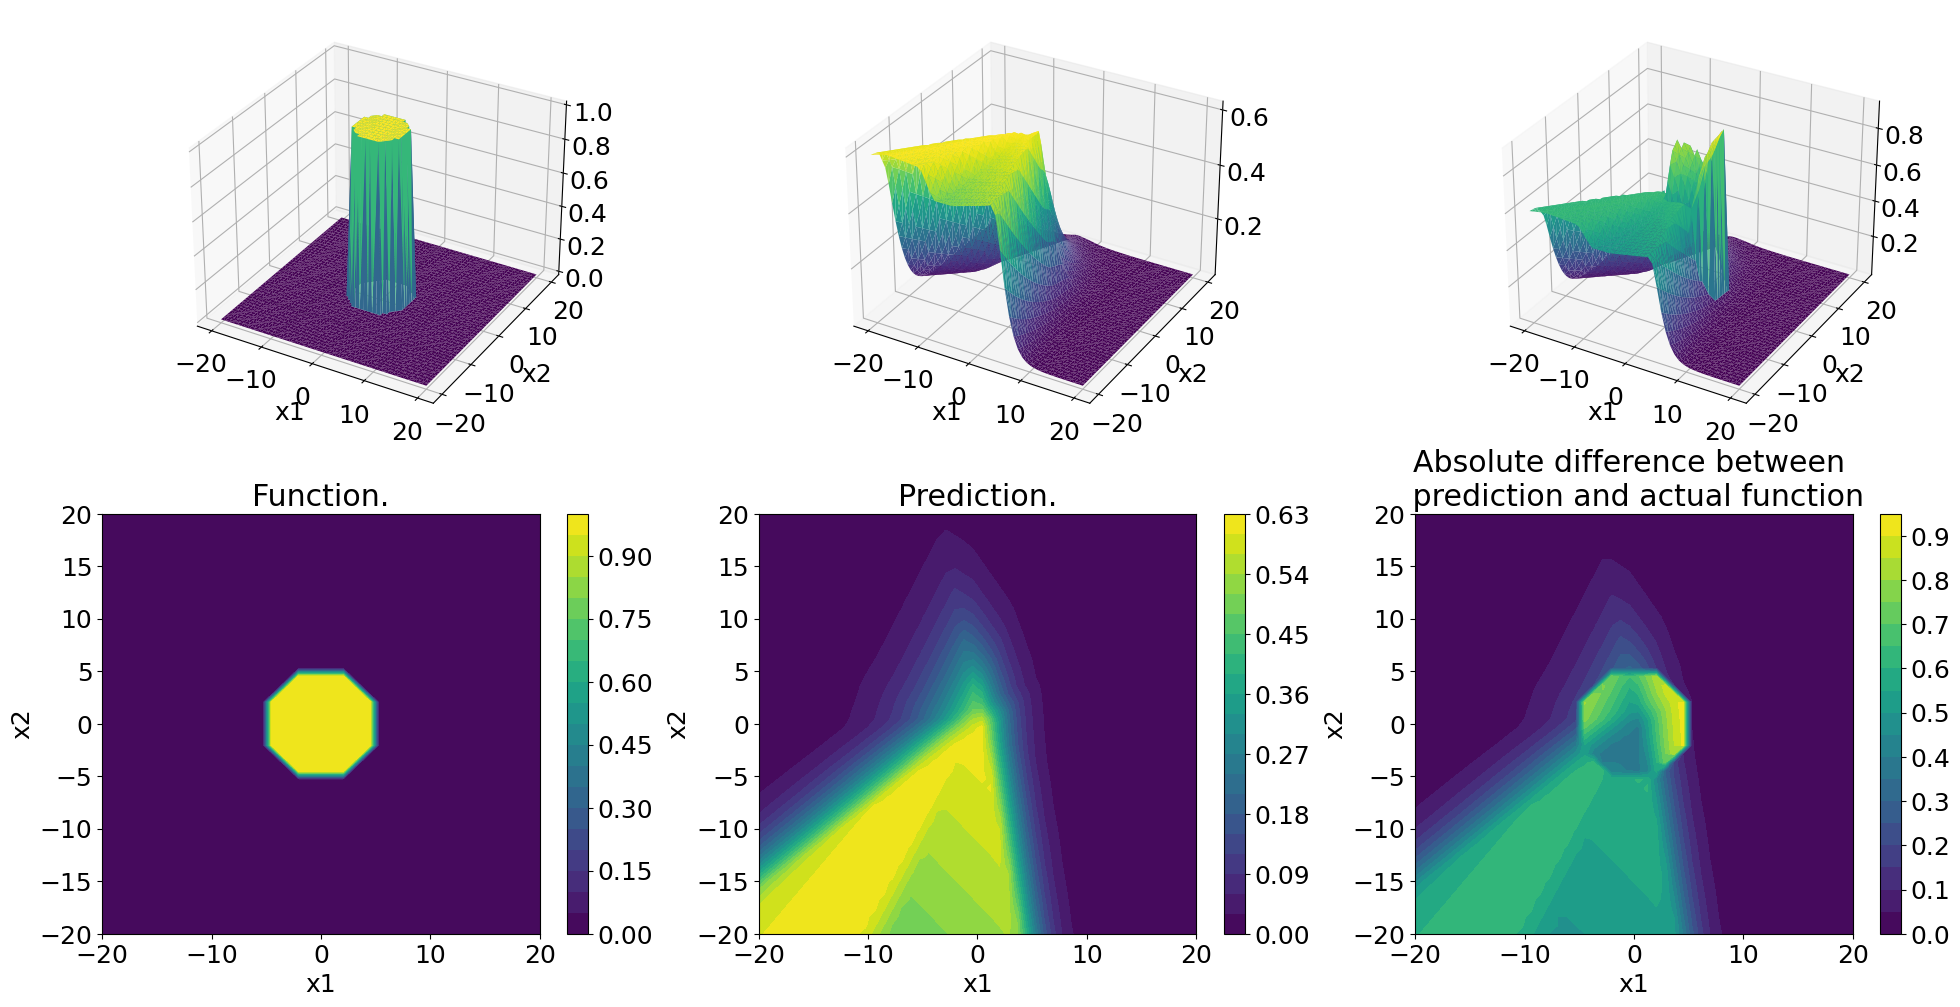

In [170]:
# from mpl_toolkits.mplot3d import Axes3D

def plot(X1, X2, Y, res):    
    fig = plt.figure(1,figsize=(24,12))
    plt.rcParams.update({'font.size': 18})
    ax = fig.add_subplot(2, 3, 1, projection='3d')
    im = ax.plot_trisurf(X1.flatten(), X2.flatten(), Y.flatten(), cmap='viridis', linewidth=0.2, antialiased=True)
    plt.xlabel('x1')
    plt.ylabel('x2')
    ax = fig.add_subplot(2, 3, 4)
    im = ax.contourf(X1, X2, Y, levels=20)
    plt.xlabel('x1')
    plt.ylabel('x2')
    fig.colorbar(im)
    plt.title('Function.')
    ax = fig.add_subplot(2,3, 2, projection='3d')
    im = ax.plot_trisurf(X1.flatten(), X2.flatten(), res.flatten(), cmap='viridis', linewidth=0.2, antialiased=True)
    plt.xlabel('x1')
    plt.ylabel('x2')
    ax = fig.add_subplot(2, 3, 5)
    im = ax.contourf(X1, X2, res, levels=20)
    plt.xlabel('x1')
    plt.ylabel('x2')
    fig.colorbar(im)
    plt.title('Prediction.')
    ax = fig.add_subplot(2,3, 3, projection='3d')
    im = ax.plot_trisurf(X1.flatten(), X2.flatten(), np.abs(res-Y).flatten(), cmap='viridis', linewidth=0.2, antialiased=True)
    plt.xlabel('x1')
    plt.ylabel('x2')
    ax = fig.add_subplot(2, 3, 6)
    im = ax.contourf(X1, X2, np.abs(res-Y), levels=20)
    plt.xlabel('x1')
    plt.ylabel('x2')
    fig.colorbar(im)
    plt.title('Absolute difference between \n prediction and actual function')
    #plt.savefig('2d_fun%d_units%d.pdf' % (fun_2d, units),bbox_inches='tight')

# r = 10
# x = np.linspace(-r, r, size).reshape(-1,1)
# y = np.linspace(-r, r, size).reshape(-1,1)
x = np.linspace(-size, size, res).reshape(-1,1)
y = np.linspace(-size, size, res).reshape(-1,1)

X,Y = np.meshgrid(x,y)
d = np.stack((X, Y), axis=-1).reshape(-1, 2)
d = torch.from_numpy(d).type(torch.DoubleTensor)
with torch.no_grad():
    corr = beta_model(d)[:,0].reshape(int(X.size**(1/2)), int(X.size**(1/2)))
    plot(X,Y, beta(X,Y), corr)